# High-NA vectorial PSF generation

Detailed models are required to generate high-NA point-spread-functions. Due to the large angles, it is crucial to take into account the vectorial nature of the electric field. This approach allows for accurate modeling of polarization and the inclusion of various correction factors.

In [40]:
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from jax import random

from chromatix.functional import gaussian_source, high_na_lens

key = random.PRNGKey(42)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


94282850.0


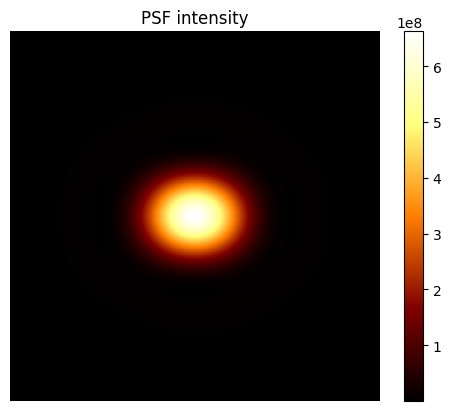

In [45]:
# Initialize model
# model = HighNAPSF()
# variables = model.init(key)
# state = variables["state"]
# del variables

camera_shape: Tuple[int, int] = (256, 256)
pupil_shape: Tuple[int, int] = (256, 256)
camera_pixel_pitch: float = 0.005
f: float = 100
NA: float = 1.3
n: float = 1.5
wavelength: float = 0.532
wavelength_ratio: float = 1.0
pad: int = 0
taper_width: Optional[float] = 0
field_pup = gaussian_source(
    pupil_shape,
    wavelength,
    wavelength_ratio,
    0,
    f,
    n,
    NA,
    power=1,
    amplitude=np.array([0.0, 0.0, 1.0]),
    offset=np.array([0.0, 0.0]),
    scalar=False,
    envelope_waist=1,
)

field = high_na_lens(field_pup, NA, camera_shape, camera_pixel_pitch, wavelength)


# field, field_pup = model.apply({"state": state})
psf_truth = (np.abs(field.u) ** 2).sum(axis=-1)

print(psf_truth.squeeze()[100, 100])

plt.figure()
plt.imshow(psf_truth.squeeze(), cmap="afmhot")
plt.colorbar()
plt.title("PSF intensity")
plt.axis("off")
plt.show()

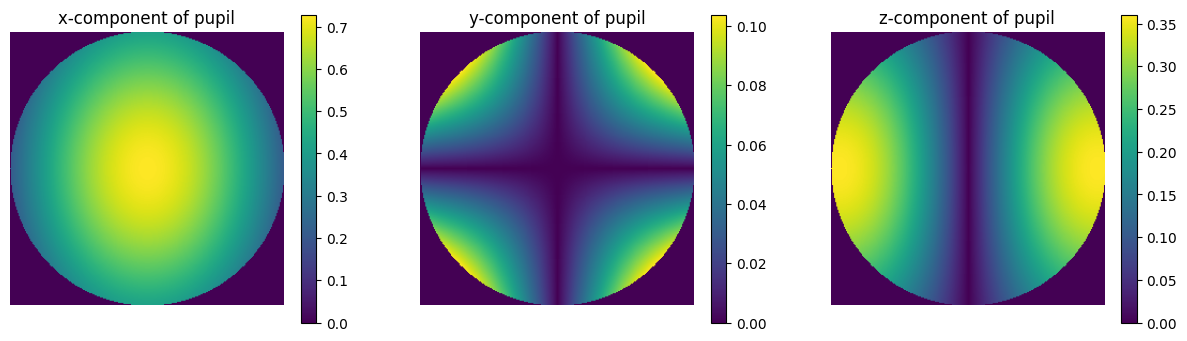

In [46]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 2])
plt.colorbar()
plt.axis("off")
plt.title("x-component of pupil")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 1])
plt.colorbar()
plt.axis("off")
plt.title("y-component of pupil")
plt.subplot(1, 3, 3)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 0])
plt.colorbar()
plt.axis("off")
plt.title("z-component of pupil")
plt.show()